# Strategy Description: Adaptive Cointegration Pairs Trading (Gold vs. Silver)

### 1. Executive Summary
This strategy employs a **Statistical Arbitrage** approach, specifically focusing on the cointegration relationship between Gold (XAU) and Silver (XAG).

A key feature of this strategy is its **Adaptive Noise Reduction mechanism**. Since Silver (XAG) exhibits significantly higher volatility than Gold, the strategy dynamically adjusts the lookback period for the Hedge Ratio ($\beta$) calculation based on the current volatility regime. This filters out short-term noise during turbulent market conditions.

### 2. Investment Universe & Specifications
* **Asset A (Y):** Gold Futures (XAU)
    * Point Value: $100
    * Transaction Cost: $15 per trade
* **Asset B (X):** Silver Futures (XAG)
    * Point Value: $5,000
    * Transaction Cost: $10 per trade
* **Data Frequency:** 5-minute bars (Intraday)

### 3. Methodology

#### A. Volatility Regime Detection
The strategy monitors the rolling volatility of Silver to determine the market state.
* **Metric:** Rolling Standard Deviation of Silver returns (1-week window).
* **Threshold:** The 80th percentile of volatility over the past month (approx. 6,000 bars).
* **Logic:**
    * **Normal Regime:** Volatility $\le$ Threshold.
    * **High Volatility Regime:** Volatility $>$ Threshold.

#### B. Adaptive Hedge Ratio (Rolling OLS)　-> Advantages of this strats!!
[Rationale] Since valatility of Silver is much higher than Gold, during high vol periods, the short-term noise can distort the Hedge Ratio estimation. To mitigate this, the strategy adapts the regression window based on the detected regime.
The Hedge Ratio ($\beta$) is calculated using Rolling OLS on the Notional Values (Dollar Values) of the assets. The window size adapts to the regime:
* **Normal Window:** 1,500 bars (approx. 1 week). Used to capture recent trends.
* **High Vol Window:** 3,000 bars (approx. 2 weeks). Used to smooth out noise when volatility is high.

#### C. Spread Construction & Z-Score
The Spread is the residual of the relationship:
$$Spread = (Price_{XAU} \times 100) - \beta_{adaptive} \times (Price_{XAG} \times 5000)$$

To identify anomalies, a rolling **Z-Score** is calculated on this spread:
* **Z-Score Window:** 300 bars.
* **Formula:** $Z = \frac{Spread - \mu_{spread}}{\sigma_{spread}}$

### 4. Trading Logic

The strategy follows a Mean Reversion logic with a strict **1-Unit Constraint**:

* **Entry Signals:**
    * **Short Spread:** If $Z > 2.0$ (Gold expensive / Silver cheap) $\rightarrow$ **Sell Gold / Buy Silver**.
    * **Long Spread:** If $Z < -2.0$ (Gold cheap / Silver expensive) $\rightarrow$ **Buy Gold / Sell Silver**.

* **Exit Signals (Mean Reversion):**
    * Positions are closed when the spread reverts to the mean area ($|Z| < 0.5$).

* **Constraints:**
    * Max Position: 1 Unit Long or 1 Unit Short per asset.
    * **Out-of-Sample (OOS):** Trading is strictly disabled during OOS periods.

### 5. Risk Management
* **Regime Adaptation:** By extending the regression window during high volatility, the strategy reduces the likelihood of false signals caused by temporary price spikes in Silver.
* **Cost Efficiency:** The strategy targets large notional deviations (due to Silver's high point value), ensuring that successful mean reversions cover the fixed transaction costs.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import warnings

# Filter warnings for cleaner output
warnings.filterwarnings('ignore')


In [8]:
# ==========================================
# 1. Configuration
# ==========================================
class Config:
    # File Path
    FILE_PATH = '../../preprocess/df_g2_processed.pkl'
    ASSETS = ['XAU', 'XAG']

    # Contract Specifications
    SPECS = {
        'XAU': {'point_val': 100.0, 'cost': 15.0},
        'XAG': {'point_val': 5000.0, 'cost': 10.0}
    }

    # --- Strategy Parameters ---

    # Beta Calculation Windows (Bars)
    # Assuming 5-min bars: 12 bars/hr * 23 hrs * 5 days ≈ 1380 bars -> approx 1500
    WINDOW_BETA_NORMAL = 1500  # 1 Week (Normal)
    WINDOW_BETA_HIGH_VOL = 3000 # 2 Weeks (High Volatility Mode)

    # Volatility Threshold Logic
    # We look at the rolling volatility of Silver over the last week.
    # If it exceeds the 80th percentile of volatility over the last month (approx 6000 bars),
    # we switch to the longer window for Beta calculation.
    VOL_PERCENTILE_LOOKBACK = 6000 # Benchmark window to define "High" (approx 1 month)
    VOL_THRESHOLD_PERCENTILE = 0.80 # Top 20% is considered "High Vol"

    # Z-Score Parameters
    WINDOW_Z = 300
    ENTRY_THRESHOLD = 2.0
    EXIT_THRESHOLD = 1.0

    ANNUALIZATION = 252

In [9]:
# ==========================================
# 2. Data Preparation (Dynamic Beta Logic)
# ==========================================
def prepare_pairs_data(file_path, cfg):
    """
    Loads data and calculates Rolling Beta and Z-Score.
    Dynamically switches Beta window based on Silver's volatility.
    """
    try:
        df = pd.read_pickle(file_path)
    except FileNotFoundError:
        print("Error: File not found.")
        return None

    req_cols = cfg.ASSETS + ['Quarter_ID']
    if 'Is_In_Sample' in df.columns:
        req_cols.append('Is_In_Sample')

    data = df[req_cols].copy()

    if 'Is_In_Sample' not in data.columns:
        data['Is_In_Sample'] = True

    print("Calculating Dynamic Beta based on Volatility...")

    def calc_cointegration_metrics(group):
        # 1. Prepare Notional Values (Dollar Value)
        # Y = Gold, X = Silver
        y = group['XAU'] * cfg.SPECS['XAU']['point_val']
        x = group['XAG'] * cfg.SPECS['XAG']['point_val']

        # 2. Calculate Volatility of Silver (X)
        # Calculate returns first
        x_ret = x.pct_change()
        # Rolling Volatility (Std Dev) over the "Normal" window (1 week)
        vol_x = x_ret.rolling(window=cfg.WINDOW_BETA_NORMAL).std()

        # 3. Define "High Volatility" Threshold
        # We compute the rolling quantile (80th percentile) of the volatility series
        # to adapt to changing market regimes.
        vol_threshold = vol_x.rolling(window=cfg.VOL_PERCENTILE_LOOKBACK).quantile(cfg.VOL_THRESHOLD_PERCENTILE)

        # Boolean Flag: Is current Vol high?
        is_high_vol = vol_x > vol_threshold

        # 4. Calculate Beta for Both Windows
        # Beta = Cov(x, y) / Var(x)

        # A. Normal Window (1 Week)
        cov_1w = x.rolling(window=cfg.WINDOW_BETA_NORMAL).cov(y)
        var_1w = x.rolling(window=cfg.WINDOW_BETA_NORMAL).var()
        beta_1w = cov_1w / var_1w

        # B. High Vol Window (2 Weeks)
        cov_2w = x.rolling(window=cfg.WINDOW_BETA_HIGH_VOL).cov(y)
        var_2w = x.rolling(window=cfg.WINDOW_BETA_HIGH_VOL).var()
        beta_2w = cov_2w / var_2w

        # 5. Select Beta based on Volatility Regime
        # np.where(condition, value_if_true, value_if_false)
        beta_final = np.where(is_high_vol, beta_2w, beta_1w)

        # 6. Calculate Spread & Z-Score
        spread = y - (beta_final * x)

        spread_mean = spread.rolling(window=cfg.WINDOW_Z).mean()
        spread_std = spread.rolling(window=cfg.WINDOW_Z).std()
        z_score = (spread - spread_mean) / spread_std

        # Assign columns
        group['Beta'] = beta_final
        group['Beta_Mode'] = np.where(is_high_vol, '2W (High Vol)', '1W (Normal)') # For debugging
        group['Spread'] = spread
        group['Z_Score'] = z_score
        group['Vol_XAG'] = vol_x

        return group

    # Apply per Quarter
    data = data.groupby('Quarter_ID', group_keys=False).apply(calc_cointegration_metrics)
    data.dropna(subset=['Z_Score'], inplace=True)

    return data

In [10]:
# ==========================================
# 3. Strategy Logic (Signal Execution)
# ==========================================
def run_pairs_strategy(df, cfg):
    """
    Executes trades based on Z-Score signals.
    """
    data = df.copy()

    z_scores = data['Z_Score'].values
    in_sample = data['Is_In_Sample'].values

    pos_xau = np.zeros(len(data), dtype=int)
    pos_xag = np.zeros(len(data), dtype=int)

    curr_pos_xau = 0
    curr_pos_xag = 0

    print(f"Simulating Pairs Strategy (Entry Z: {cfg.ENTRY_THRESHOLD}, Exit Z: {cfg.EXIT_THRESHOLD})...")

    for i in range(len(data)):
        if not in_sample[i]:
            curr_pos_xau = 0
            curr_pos_xag = 0
            pos_xau[i] = 0
            pos_xag[i] = 0
            continue

        z = z_scores[i]

        # --- Trading Logic ---

        # Check Entry
        if curr_pos_xau == 0:
            if z > cfg.ENTRY_THRESHOLD:
                curr_pos_xau = -1 # Short Spread (Sell Gold, Buy Silver)
                curr_pos_xag = 1
            elif z < -cfg.ENTRY_THRESHOLD:
                curr_pos_xau = 1  # Long Spread (Buy Gold, Sell Silver)
                curr_pos_xag = -1

        # Check Exit (Mean Reversion)
        else:
            if abs(z) < cfg.EXIT_THRESHOLD:
                curr_pos_xau = 0
                curr_pos_xag = 0

        pos_xau[i] = curr_pos_xau
        pos_xag[i] = curr_pos_xag

    data['Pos_XAU'] = pd.Series(pos_xau, index=data.index).shift(1).fillna(0)
    data['Pos_XAG'] = pd.Series(pos_xag, index=data.index).shift(1).fillna(0)

    return data

In [11]:
# ==========================================
# 4. P&L Calculation & Aggregation
# ==========================================
def calculate_metrics(data, cfg):
    """
    Calculates P&L and aggregates to Daily.
    """
    df = data.copy()

    df['dPrice_XAU'] = df['XAU'].diff()
    df['dPrice_XAG'] = df['XAG'].diff()

    df['Gross_PnL_XAU'] = df['Pos_XAU'] * df['dPrice_XAU'] * cfg.SPECS['XAU']['point_val']
    df['Gross_PnL_XAG'] = df['Pos_XAG'] * df['dPrice_XAG'] * cfg.SPECS['XAG']['point_val']
    df['Gross_PnL_Total'] = df['Gross_PnL_XAU'] + df['Gross_PnL_XAG']

    df['Trades_XAU'] = df['Pos_XAU'].diff().abs().fillna(0)
    df['Trades_XAG'] = df['Pos_XAG'].diff().abs().fillna(0)

    df['Cost_Total'] = (df['Trades_XAU'] * cfg.SPECS['XAU']['cost']) + \
                       (df['Trades_XAG'] * cfg.SPECS['XAG']['cost'])

    df['Net_PnL_Total'] = df['Gross_PnL_Total'] - df['Cost_Total']
    df['Total_Trades'] = df['Trades_XAU'] + df['Trades_XAG']

    daily_stats = df.resample('D').agg({
        'Gross_PnL_Total': 'sum',
        'Net_PnL_Total': 'sum',
        'Total_Trades': 'sum',
        'Trades_XAU': 'sum',
        'Trades_XAG': 'sum',
        'Quarter_ID': 'last',
        'Is_In_Sample': 'last'
    })

    daily_stats = daily_stats[daily_stats['Quarter_ID'].notna()]
    daily_stats = daily_stats[daily_stats['Is_In_Sample'] == True]

    return daily_stats

In [12]:
# ==========================================
# 5. Performance Stats & Reporting
# ==========================================
def generate_quarterly_stats(daily_df, cfg):
    """
    Generates summary statistics table.
    """
    if daily_df.empty:
        return pd.DataFrame()

    quarters = sorted(daily_df['Quarter_ID'].unique())
    stats_list = []

    for q in quarters:
        d_q = daily_df[daily_df['Quarter_ID'] == q].copy()

        if len(d_q) == 0:
            continue

        gross_cum_pnl = d_q['Gross_PnL_Total'].sum()
        net_cum_pnl = d_q['Net_PnL_Total'].sum()

        mean_g = d_q['Gross_PnL_Total'].mean()
        std_g = d_q['Gross_PnL_Total'].std()
        gross_sr = (mean_g / std_g * np.sqrt(cfg.ANNUALIZATION)) if std_g != 0 else 0

        mean_n = d_q['Net_PnL_Total'].mean()
        std_n = d_q['Net_PnL_Total'].std()
        net_sr = (mean_n / std_n * np.sqrt(cfg.ANNUALIZATION)) if std_n != 0 else 0

        ann_vol_n = std_n * np.sqrt(cfg.ANNUALIZATION)

        years = len(d_q) / cfg.ANNUALIZATION

        equity_g = d_q['Gross_PnL_Total'].cumsum()
        max_dd_g = (equity_g.cummax() - equity_g).max()
        gross_cr = (gross_cum_pnl / years / max_dd_g) if (max_dd_g > 0) else 0

        equity_n = d_q['Net_PnL_Total'].cumsum()
        max_dd_n = (equity_n.cummax() - equity_n).max()
        net_cr = (net_cum_pnl / years / max_dd_n) if (max_dd_n > 0) else 0

        trades_xau = d_q['Trades_XAU'].sum()
        trades_xag = d_q['Trades_XAG'].sum()
        av_ntrades = d_q['Total_Trades'].mean()

        # Summary Statistic
        abs_pnl_scaled = abs(net_cum_pnl) / 1000.0
        log_term = np.log(abs_pnl_scaled) if abs_pnl_scaled > 0 else 0
        term_2 = max(0, log_term)
        stat = (net_sr - 0.5) * term_2

        stats_list.append({
            'Quarter': q,
            'Gross SR': gross_sr,
            'Net SR': net_sr,
            'Ann. Vol ($)': ann_vol_n,
            'Gross CR': gross_cr,
            'Net CR': net_cr,
            'Gross CumP&L': gross_cum_pnl,
            'Net CumP&L': net_cum_pnl,
            'Trades (Au)': trades_xau,
            'Trades (Ag)': trades_xag,
            'Av. Trades': av_ntrades,
            'Stat': stat
        })

    return pd.DataFrame(stats_list)

def plot_equity_curve(daily_stats):
    if daily_stats is None or daily_stats.empty:
        return

    quarters = sorted(daily_stats['Quarter_ID'].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, len(quarters)))

    plt.figure(figsize=(15, 8))

    daily_stats['Global_Equity'] = daily_stats['Net_PnL_Total'].cumsum()

    for i, q in enumerate(quarters):
        d_q = daily_stats[daily_stats['Quarter_ID'] == q]
        plt.plot(d_q.index, d_q['Global_Equity'], label=q, color=colors[i], lw=2)

    plt.title('Cointegration Strategy (Adaptive Beta): Net Cumulative Equity')
    plt.ylabel('Cumulative Profit ($)')
    plt.xlabel('Date')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

Calculating Dynamic Beta based on Volatility...
Simulating Pairs Strategy (Entry Z: 2.0, Exit Z: 1.0)...

 PERFORMANCE REPORT: Adaptive Cointegration Strategy

[Text Output]
   Quarter  Gross SR    Net SR  Ann. Vol ($)   Gross CR     Net CR  Gross CumP&L  Net CumP&L  Trades (Au)  Trades (Ag)  Av. Trades       Stat
0  2023_Q1 -0.610512 -0.978013  14294.446086  -1.017934  -1.462895       -2377.9     -3827.9         58.0         58.0    1.681159  -1.983961
1  2023_Q3 -0.513465 -0.807197  12542.966285  -0.880890  -1.349107       -1787.4     -2812.4         41.0         41.0    1.171429  -1.351691
2  2023_Q4  2.216116  1.838106  14375.273714   4.286366   3.411524        8864.8      7339.8         61.0         61.0    1.742857   2.667263
3  2024_Q2  2.662477  2.326808  19712.797291   9.878908   8.418137       14748.1     12923.1         73.0         73.0    2.056338   4.674833
4  2024_Q4 -0.179052 -0.282762  45592.729098  -1.538892  -2.406552       -2333.4     -3683.4         54.0         54

,Quarter,Gross SR,Net SR,Ann. Vol ($),Gross CR,Net CR,Gross CumP&L,Net CumP&L,Trades (Au),Trades (Ag),Av. Trades,Stat
0,2023_Q1,-0.61,-0.98,"$14,294",-1.02,-1.46,"$-2,378","$-3,828",58,58,1.7,-1.9840
1,2023_Q3,-0.51,-0.81,"$12,543",-0.88,-1.35,"$-1,787","$-2,812",41,41,1.2,-1.3517
2,2023_Q4,2.22,1.84,"$14,375",4.29,3.41,"$8,865","$7,340",61,61,1.7,2.6673
3,2024_Q2,2.66,2.33,"$19,713",9.88,8.42,"$14,748","$12,923",73,73,2.1,4.6748
4,2024_Q4,-0.18,-0.28,"$45,593",-1.54,-2.41,"$-2,333","$-3,683",54,54,1.5,-1.0206
5,2025_Q1,4.56,4.35,"$21,177",18.59,16.60,"$26,462","$25,212",50,50,1.4,12.4191
6,2025_Q2,5.76,5.63,"$47,823",36.67,35.48,"$77,594","$75,819",71,71,2.0,22.1919
7,TOTAL,-,-,"$29,307",-,-,"$121,170","$110,970",408,408,1.7,37.5968



 TOTAL RANKING SCORE: 37.5968


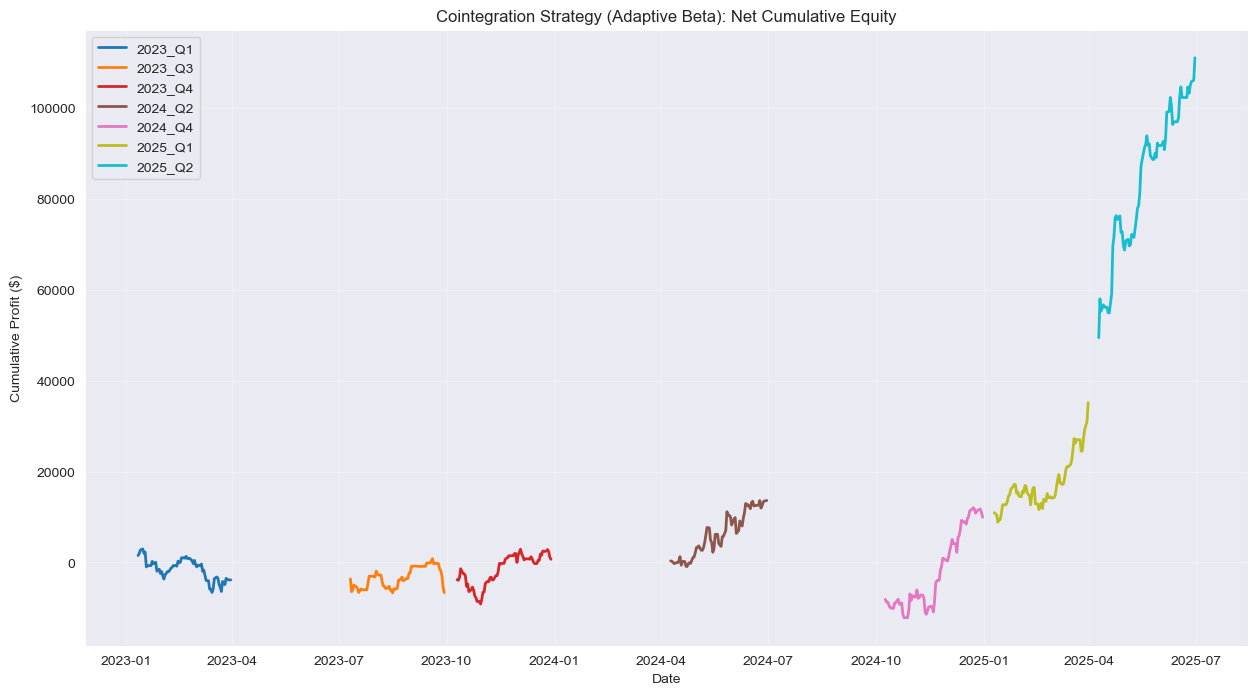

In [13]:
# ==========================================
# 6. Main Execution
# ==========================================
if __name__ == "__main__":
    cfg = Config()

    # 1. Prepare Data (with Dynamic Beta)
    df_prep = prepare_pairs_data(cfg.FILE_PATH, cfg)

    if df_prep is not None:
        # 2. Run Strategy
        df_res = run_pairs_strategy(df_prep, cfg)

        # 3. Calculate Metrics
        daily_data = calculate_metrics(df_res, cfg)

        # 4. Generate Report
        stats_table = generate_quarterly_stats(daily_data, cfg)

        # --- Display Table ---
        print("\n" + "="*80)
        print(" PERFORMANCE REPORT: Adaptive Cointegration Strategy")
        print("="*80)

        if not stats_table.empty:
            total_score = stats_table['Stat'].sum()
            total_gross_pnl = stats_table['Gross CumP&L'].sum()
            total_net_pnl = stats_table['Net CumP&L'].sum()
            total_trades_au = stats_table['Trades (Au)'].sum()
            total_trades_ag = stats_table['Trades (Ag)'].sum()

            std_global = daily_data['Net_PnL_Total'].std()
            vol_global = std_global * np.sqrt(cfg.ANNUALIZATION)

            display_df = stats_table.copy()
            sum_row = pd.DataFrame([{
                'Quarter': 'TOTAL',
                'Gross SR': np.nan,
                'Net SR': np.nan,
                'Ann. Vol ($)': vol_global,
                'Gross CR': np.nan,
                'Net CR': np.nan,
                'Gross CumP&L': total_gross_pnl,
                'Net CumP&L': total_net_pnl,
                'Trades (Au)': total_trades_au,
                'Trades (Ag)': total_trades_ag,
                'Av. Trades': stats_table['Av. Trades'].mean(),
                'Stat': total_score
            }])

            display_df = pd.concat([display_df, sum_row], ignore_index=True)

            format_dict = {
                'Gross SR': '{:.2f}', 'Net SR': '{:.2f}',
                'Ann. Vol ($)': '${:,.0f}',
                'Gross CR': '{:.2f}', 'Net CR': '{:.2f}',
                'Gross CumP&L': '${:,.0f}', 'Net CumP&L': '${:,.0f}',
                'Trades (Au)': '{:,.0f}', 'Trades (Ag)': '{:,.0f}',
                'Av. Trades': '{:.1f}',
                'Stat': '{:.4f}'
            }

            print("\n[Text Output]")
            print(display_df.to_string(formatters={k: v.format for k, v in format_dict.items() if isinstance(v, str) == False}, na_rep="-"))

            print("\n[Table Output]")
            try:
                subset_stat = pd.IndexSlice[0:len(display_df)-2, ['Stat']]
                styled_df = display_df.style.format(format_dict, na_rep="-")\
                                            .background_gradient(subset=subset_stat, cmap='RdYlGn')\
                                            .apply(lambda x: ['font-weight: bold' if x.name == len(display_df)-1 else '' for i in x], axis=1)
                display(styled_df)
            except:
                display(display_df)

            print(f"\n{'='*40}")
            print(f" TOTAL RANKING SCORE: {total_score:.4f}")
            print(f"{'='*40}")
        else:
            print("⚠️ No statistics generated.")

        # 5. Plot
        plot_equity_curve(daily_data)